In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as sps
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import os
import matplotlib.pyplot as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Load the primary data source of MTA fare swipes. Will initially try working from a Pandas Panel.

In [2]:
fil = os.getenv("PUIDATA") + "/MTA_Fare.npy"
np_fares = np.load(fil)
# np.nan exists only for type float, so need to recast the array in order
# to assign the invalid cells to NaN AND have it behave as it should.
np_fares = np_fares.astype(float)

In [3]:
np_fares.shape

(600, 23, 194)

In [4]:
weeks = pd.date_range('5/21/2010', periods=194, freq='W-FRI')
rtypes = np.array(['r10t', 'u14d', 'u1d', 'r2t', 'u30d', 'u7d', 'ada',
                   'afas', 'exp', 'ez', 'ff', 'mc', 'mr', 'month', 'rfm', 'rr',
                   'sen', 'spec', 'tcmc', 'tkt', 'unl', 'xbus', 'student'])

In [5]:
fares = pd.Panel(np_fares, major_axis=rtypes, minor_axis=weeks)
fares.describe

<bound method Panel.describe of <class 'pandas.core.panel.Panel'>
Dimensions: 600 (items) x 23 (major_axis) x 194 (minor_axis)
Items axis: 0 to 599
Major_axis axis: r10t to student
Minor_axis axis: 2010-05-21 00:00:00 to 2014-01-31 00:00:00>

In [6]:
fares[0].columns

DatetimeIndex(['2010-05-21', '2010-05-28', '2010-06-04', '2010-06-11',
               '2010-06-18', '2010-06-25', '2010-07-02', '2010-07-09',
               '2010-07-16', '2010-07-23',
               ...
               '2013-11-29', '2013-12-06', '2013-12-13', '2013-12-20',
               '2013-12-27', '2014-01-03', '2014-01-10', '2014-01-17',
               '2014-01-24', '2014-01-31'],
              dtype='datetime64[ns]', length=194, freq='W-FRI')

Many of the cells in the array have no data, represented by a value of -1. If this is unaccounted for when adding up across an axis, it could distort the results. In order to address this, any cell with a value of -1 will be set to NaN. This is done by looping through each item of the Panel and then each column of the item (major axis) and using the Pandas function to set everything equals -1 to np.nan

In [7]:
for sta in range(600):
    for wk in weeks:
        fares[sta].loc[fares[sta][wk] == -1, wk] = np.nan

In [8]:
fares.axes

[RangeIndex(start=0, stop=600, step=1),
 Index([u'r10t', u'u14d', u'u1d', u'r2t', u'u30d', u'u7d', u'ada', u'afas',
        u'exp', u'ez', u'ff', u'mc', u'mr', u'month', u'rfm', u'rr', u'sen',
        u'spec', u'tcmc', u'tkt', u'unl', u'xbus', u'student'],
       dtype='object'),
 DatetimeIndex(['2010-05-21', '2010-05-28', '2010-06-04', '2010-06-11',
                '2010-06-18', '2010-06-25', '2010-07-02', '2010-07-09',
                '2010-07-16', '2010-07-23',
                ...
                '2013-11-29', '2013-12-06', '2013-12-13', '2013-12-20',
                '2013-12-27', '2014-01-03', '2014-01-10', '2014-01-17',
                '2014-01-24', '2014-01-31'],
               dtype='datetime64[ns]', length=194, freq='W-FRI')]

Collapse the data by station and by fare type. This will create two DataFrames indexed by week, one with columns of stations and one with columns of fare types.

In [9]:
coll_sta = fares.sum(axis=1, skipna=True)
coll_sta.shape

(194, 600)

In [11]:
coll_sta.head(3)

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
2010-05-21,126878.0,37306.0,6606.0,16378.0,18564.0,19987.0,12449.0,11091.0,10482.0,147187.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-28,149477.0,46464.0,6881.0,17408.0,19903.0,20625.0,13644.0,11659.0,11030.0,154826.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-06-04,152383.0,49359.0,7229.0,17595.0,19948.0,21225.0,13719.0,12037.0,10881.0,155958.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Table 1. The total rides by station for the first three weeks.

In [12]:
coll_types = fares.sum(axis=0, skipna=True).transpose()
coll_types.shape

(194, 23)

In [13]:
coll_types.head(3)

,r10t,u14d,u1d,r2t,u30d,u7d,ada,afas,exp,ez,...,month,rfm,rr,sen,spec,tcmc,tkt,unl,xbus,student
2010-05-21,11494615.0,530524.0,47801.0,186551.0,46808.0,3697443.0,8551937.0,10063.0,333197.0,512032.0,...,123134.0,790110.0,59809.0,28221.0,0.0,124693.0,21060.0,6128.0,358.0,NaN
2010-05-28,12526859.0,583533.0,51486.0,199229.0,64353.0,3981808.0,9486394.0,11847.0,282755.0,578023.0,...,151948.0,908068.0,69209.0,32333.0,0.0,121713.0,21670.0,6120.0,474.0,NaN
2010-06-04,12766627.0,586194.0,51636.0,199668.0,56994.0,4033030.0,9476538.0,12277.0,302028.0,615537.0,...,151538.0,914124.0,69574.0,32618.0,0.0,122181.0,21433.0,6490.0,465.0,NaN


Table 2. The total rides by fare type for the first three weeks.

In [14]:
# Verify that the two frames each add up to the same thing
print(coll_types.sum().sum())
coll_sta.sum().sum()

5777581875.0


5777581875.0

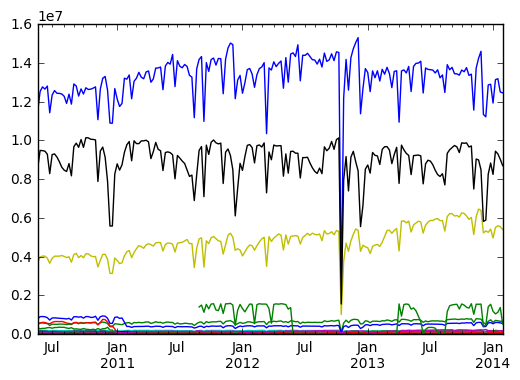

In [18]:
for col in coll_types.columns:
    coll_types[col].plot()

### Task 1
Detect the event that saw a $> 3\sigma$ drop in ridership.

First step is to collapse all the data to total by week. Divide by 1000 to put everything in a proper scale. Calculate the mean and standard deviation from this Series and plot, adding a dashed line to show mean, and 1 and 3 standard deviations off.

In [21]:
collapse = coll_sta.sum(axis=1, skipna=True) / 1000
collapse.shape

(194,)

In [22]:
mean_rides = collapse.mean()
std_rides = collapse.std()

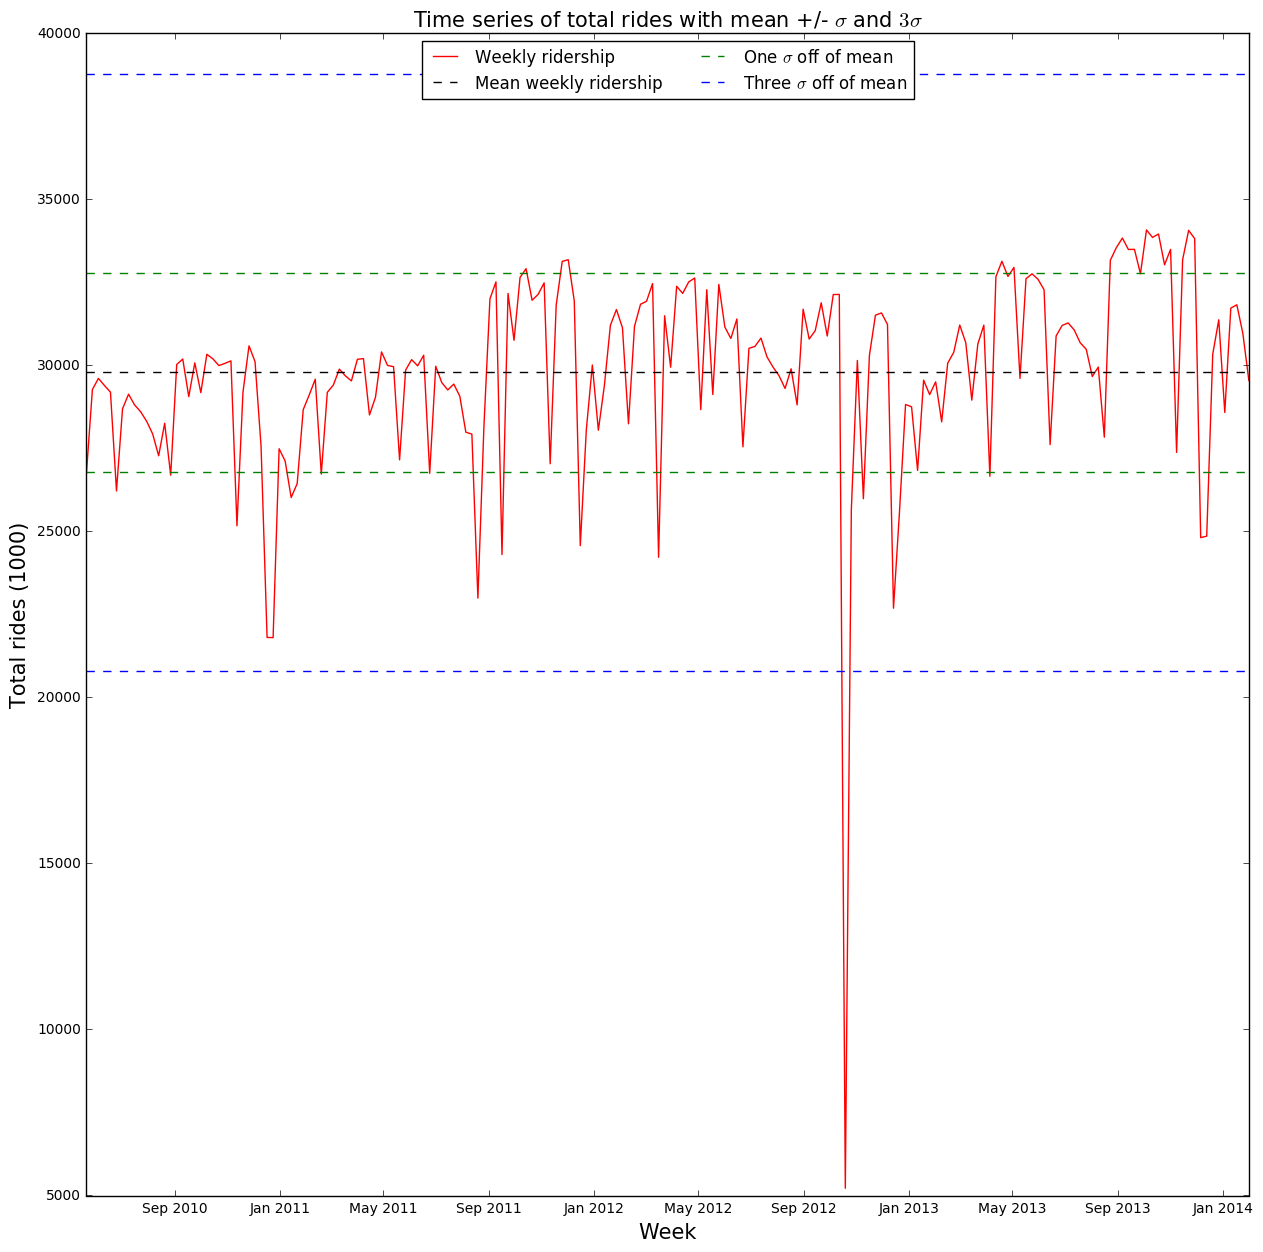

In [34]:
fig = pl.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
ser_start = collapse.index[0]
ser_end = collapse.index[-1]
ax.plot(collapse.index, collapse, "r-", label="Weekly ridership")
ser_st_en = [ser_start, ser_end]
ax.plot(ser_st_en, [mean_rides, mean_rides], "k--", label="Mean weekly ridership")
ax.plot([ser_start, ser_start], [mean_rides, mean_rides],
        "g--", label="One $\\sigma$ off of mean")
ax.plot([ser_start, ser_start], [mean_rides, mean_rides],
        "b--", label="Three $\\sigma$ off of mean")
for fact in -1, 1:
    ax.plot(ser_st_en, [mean_rides + fact * std_rides, mean_rides + fact * std_rides], "g--")
    ax.plot(ser_st_en, [mean_rides + 3 * fact * std_rides,
                        mean_rides + 3 * fact * std_rides], "b--")
ax.set_title("Time series of total rides with mean +/- $\\sigma$ and $3\\sigma$", fontsize=15)
pl.ylabel("Total rides (1000)", fontsize=15)
pl.xlabel("Week", fontsize=15)
pl.legend(loc='upper center', ncol=2)

Figure 1. Shows the variation of total ridership per week from May 2010 until February 2014. Includes a sharp drop sometime around October 2012 of roughly $7\sigma$ from the mean.

In [29]:
outliers = collapse.loc[collapse < 20000]
outliers

2012-10-19    5218.686
Freq: W-FRI, dtype: float64

The week starting October 19, 2012 had a shutdown due to Hurricane Sandy. The system was shutdown the day before the storm and it took several days afterwards in order restore power to resume service.